In [7]:
from SOH_func import *
import matplotlib.pyplot as pl
from tensorflow import keras
from keras import models, layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
# from sklearn.preprocessing import StandardScaler

# %load_ext tensorboard

In [8]:
FILE_NAME = 'CYCLE_CSV_data.csv'
# drop_labels = ['시험_시간(s)', '사이클_번호', '사이클_시간(s)', '단계_번호', '단계_시간(s)', '인덱스', '보조전압1(V)', '보조전압2(V)', '보조전압3(V)', '온도(\'C)', '누적_용량(Ah)', '전류_범위', 'OCP(V)', '파워(W)', '부하(Ohm)']
drop_labels_x = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '단위_충전_용량(Ah/g)', '단위_방전_용량(Ah/g)']
drop_labels_y = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '방전_최종전압(V)', '단위_충전_용량(Ah/g)', '단위_방전_용량(Ah/g)']
y_label = '절대값_용량(Ah)'

Index(['방전_용량(Ah)', '방전_에너지(Wh)', '방전_최종전압(V)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data = (510, 3)
data_cap = (510, 1)


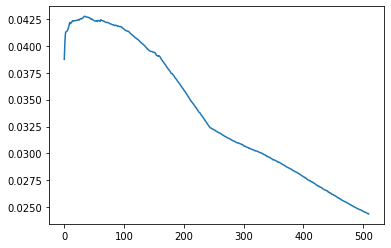

In [9]:
data, data_cap = get_data(FILE_NAME, drop_labels_x, drop_labels_y)
print(f'data = {data.shape}')
print(f'data_cap = {data_cap.shape}')
pl.plot(data_cap)
pl.show()

In [10]:
seq_len = 25
sample_len = 8
num_units = 256
num_filters = 6
window = 3
drop_rate = 0.2
num_epochs = 5000
x_data, y_data, num_batch = seq_gen(data, data_cap, seq_len)
x_train, y_train, num_batch = seq_gen(x_data, y_data, sample_len)
print(x_train.shape)

num_batch = 20
x = (20, 25, 3)
y = (20, 25, 1)
num_batch = 2
x = (2, 8, 25, 3)
y = (2, 8, 25, 1)
(2, 8, 25, 3)


In [11]:
model = models.Sequential()
model.add(layers.ConvLSTM1D(num_filters, window, return_sequences=True, padding="same", input_shape = (None, x_train.shape[-2], x_train.shape[-1])))
model.add(layers.Dense(1))
model.compile(loss = 'mse', optimizer = 'Adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d_1 (ConvLSTM1D)  (None, None, 25, 6)       672       
                                                                 
 dense_1 (Dense)             (None, None, 25, 1)       7         
                                                                 
Total params: 679
Trainable params: 679
Non-trainable params: 0
_________________________________________________________________


In [12]:
epoch_index = 0
loss_dict = {}
epoch_index += num_epochs
callback_list = [ModelCheckpoint(filepath = f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5', monitor = 'val_loss', save_best_only = True)]
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 1, validation_split=0.2, callbacks=callback_list)

Epoch 1/5000
1/1 [==============================] - 2s 2s/step - loss: 0.0032 - val_loss: 0.0026
Epoch 2/5000
1/1 [==============================] - 0s 150ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 3/5000
1/1 [==============================] - 0s 126ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/5000
1/1 [==============================] - 0s 109ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/5000
1/1 [==============================] - 0s 100ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 6/5000
1/1 [==============================] - 0s 100ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/5000
1/1 [==============================] - 0s 114ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 8/5000
1/1 [==============================] - 0s 104ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 9/5000
1/1 [==============================] - 0s 97ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 10/5000
1/1 [==============================] - 0s 90ms/step - loss: 0.0017 - val_loss: 0.0013
Epoc

In [15]:
model.load_weights(f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5')
loss = model.evaluate(x_train, y_train)
loss_dict[f'loss_{epoch_index}'] = loss 
prediction = model.predict(x_train)
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1] * prediction.shape[2]), 1) 
y_graph = y_train.reshape(int(y_train.shape[0] * y_train.shape[1] * y_train.shape[2]), 1)
print(prediction.shape, y_graph.shape)

1/1 [==============================] - 0s 33ms/step
(400, 1) (400, 1)


256 units, 5000 epochs, sequence length = 25


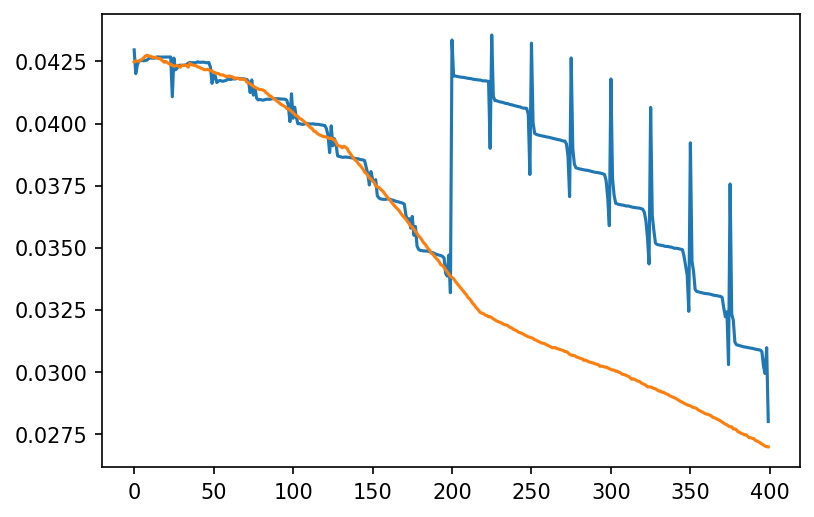

FileNotFoundError: [Errno 2] No such file or directory: 'ouputs/out_6fil256memc5000epoch25seq.png'

<Figure size 432x288 with 0 Axes>

In [16]:
print(f'{num_units} units, {epoch_index} epochs, sequence length = {seq_len}')
pl.figure(dpi=150) # 해상도(default = 100)
pl.plot(prediction)
pl.plot(y_graph)
pl.show()